In [ ]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2018-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [1]:
import nxsdk.api.n2a as nx
import numpy as np
import matplotlib.pyplot as plt
import os

# SNIPs
In this tutorial we demonstrate the configuration of SNIPs and communication among SNIPs and between SNIPs and the SNN. The following figure illustrates the how SNIPs interact.

<img src="../figures/jupyter_snips.png">

As an example, we stimulate a single compartment with a spike generator but vary the membrane threshold over time via a SNIP. We send the new membrane threshold value from the super host to a SNIP executing in the management phase on the embedded Lakemont processor via a channel and return the time of modification to the super host via another channel.

## Setup compartment and spike generator

In [2]:
net = nx.NxNet()

# Create a single compartment
cxProto = nx.CompartmentPrototype(vThMant=150,
                                  compartmentCurrentDecay=int(1/10*2**12),
                                  compartmentVoltageDecay=int(1/20*2**12),
                                  logicalCoreId=0)
cx = net.createCompartmentGroup(size=1, prototype=cxProto)

# Create spike generator and schedule spikes every 'dt' time steps to be sent to the compartment
sg = net.createSpikeGenProcess(numPorts=1)
dt = 10
numSteps = 1000
sg.addSpikes(0, list(range(dt, numSteps, dt)))

# Connect spike generator to compartment
connProto = nx.ConnectionPrototype(weight=10)
sg.connect(cx, prototype=connProto)

## Configure current, voltage and spike probe

In [3]:
uProbe = cx.probe(nx.ProbeParameter.COMPARTMENT_CURRENT)[0][0]
vProbe = cx.probe(nx.ProbeParameter.COMPARTMENT_VOLTAGE)[0][0]
sProbe = cx.probe(nx.ProbeParameter.SPIKE)[0][0]

## Compile network and retrieve board

In [4]:
compiler = nx.N2Compiler()
board = compiler.compile(net)

## Configure SNIP and channels 
In this tutorial, the C code for SNIP can be written at NxCore level, or it can be upleveled using NxNet C API. In the code below, setVTh_core.c is used for SNIP at NxCore level, and setVTh_net.c is used for SNIP at NxNet level using NxNet C API. For more details about NxNet C API, please refer to the documentation.

In [5]:
# Define directory where SNIP C-code is located
includeDir = os.getcwd()

# Create SNIP, define which code to execute and in which phase of the NxRuntime execution cycle
mgmtSnip = board.createProcess(
    name="runMgmt",
    includeDir=includeDir,
    cFilePath=includeDir + "/setVTh_core.c", # NxCore level C file
#     cFilePath=includeDir + "/setVTh_net.c",  # NxNet level C file
    funcName="runMgmt", 
    guardName="doRunMgmt", 
    phase="mgmt")

# Create a channel from super host to Lakemont for sending new vTh values
# The name of the channel is vThChannel, it supports elements of type int, and has a maximum capacity of 1 element
vThChannel = board.createChannel(b'vThChannel', "int", 1)
# Sending process is the super host (denoted by None) with mgmtSnip as the receiving process
vThChannel.connect(None, mgmtSnip)

# Create a channel from Lakemont to super host for sending the time of modification
# The name of the channel is timeChannel, it supports elements of type int, and has a maximum capacity of 1 element
timeChannel = board.createChannel(b'timeChannel', "int", 1)
# Sending process is the mgmtSnip and the receiving process is the super host (denoted by None)
timeChannel.connect(mgmtSnip, None)

# Start driver
board.startDriver()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.80:18861


## Define sequence of new membrane potential values

In [6]:
times = []
numIntervals = 10
vThVals = [200, 150] * (int(numIntervals/2))

## Execute network, send threshold values and receive modification times

In [7]:
# Add initial element in channel otherwise snip might miss it before Python on super host gets to send next element
vThChannel.write(1, [vThVals[0]])

# Launch execution
board.run(numSteps, aSync=True)

# Read time of last vTh modification from channel and write next vTh value to channel
for vth in vThVals[1:]:
    times.append(timeChannel.read(1)[0])
    vThChannel.write(1, [vth])

# Finish and disconnect
board.finishRun()
board.disconnect()

## Visualize results

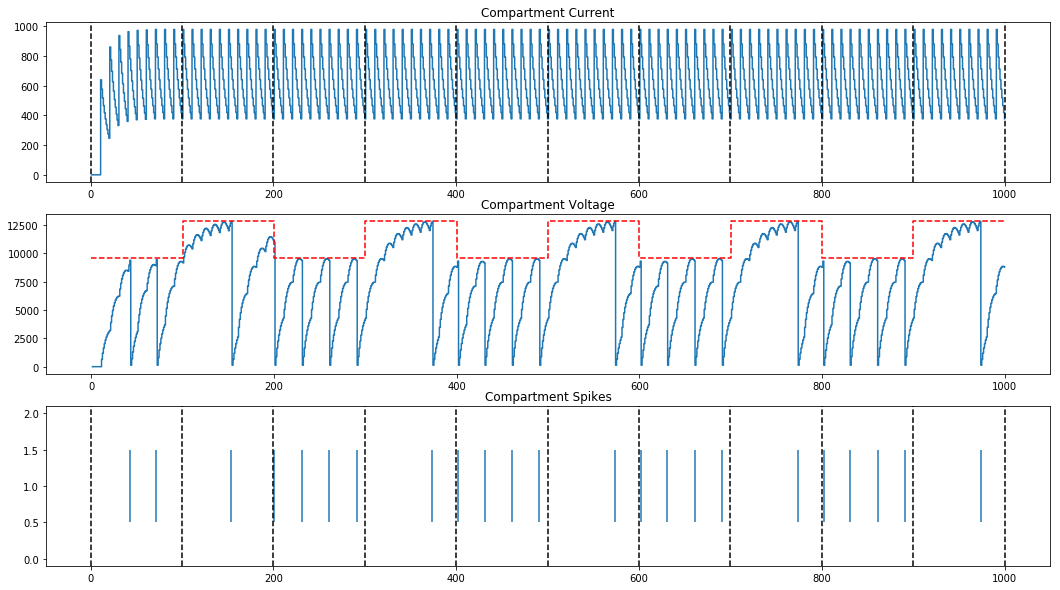

In [8]:
# Add initial and final values to 'times' and 'vThVals' that have not been sent for plotting
times.insert(0, 0)
times.append(1000)
vThVals.insert(0, 150)
vThVals.insert(0, 150)
vThVals = vThVals[:-1]

# Helper method to draw vertical interval separators whenever we change vTh
def drawIntervalSeperators(intervalBoundaries):
    for t in intervalBoundaries:
        plt.axvline(x=t, color='k', linestyle='--')

# Plot compartment current, voltage and spikes
plt.figure(1, figsize=(18,10))

ax1 = plt.subplot(3, 1, 1)
uProbe.plot()
plt.title('Compartment Current')
drawIntervalSeperators(times)

ax2 = plt.subplot(3, 1, 2)
vProbe.plot()
plt.title('Compartment Voltage')
plt.step(times, np.array(vThVals)*2**6, color='r', linestyle='--')

ax3 = plt.subplot(3, 1, 3)
sProbe.plot()
plt.title('Compartment Spikes')
drawIntervalSeperators(times)
ax3.set_xlim(ax1.get_xlim())

plt.show()